In [1]:
import collections
import pathlib

# データ処理周り
import numpy as np
import pandas as pd
from IPython.core.display import display
import gc

# 可視化ライブラリ
import matplotlib.pyplot as plt
from matplotlib import cm # colormap
import seaborn as sns
%matplotlib inline

# pandasのwarningが邪魔なので
import warnings
warnings.filterwarnings('ignore')

# options
# pd.set_option('display.max_columns', 50)
plt.style.use('ggplot')


####
import sys
sys.path.append('../script')
data_path = pathlib.Path('../data')
my_data_path = pathlib.Path('../my-data')

In [2]:
# %reload_ext autoreload
import talking_data as td
import preprocess 


from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance

In [3]:
# BigQueryで前処理済みのデータを1/10ロード
train = pd.DataFrame()

i = 0
n = 30
for filepath in (my_data_path / 'train_expanded').glob('*.tar.gz'):
    print(f">>> {i}")
    if i > n:
        break        
    df = pd.read_csv(filepath)
    train = pd.concat([train, df])
    i += 1

>>> 0
>>> 1
>>> 2
>>> 3
>>> 4
>>> 5
>>> 6
>>> 7
>>> 8
>>> 9
>>> 10
>>> 11
>>> 12
>>> 13
>>> 14
>>> 15
>>> 16
>>> 17
>>> 18
>>> 19
>>> 20
>>> 21
>>> 22
>>> 23
>>> 24
>>> 25
>>> 26
>>> 27
>>> 28
>>> 29
>>> 30
>>> 31


In [4]:
test = pd.DataFrame()
for filepath in (my_data_path / 'test_expanded').glob('*.tar.gz'):
    df = pd.read_csv(filepath)
    test = pd.concat([test, df])

In [5]:
# train
print("shape:", train.shape)
train.head()

shape: (57322243, 11)


,app,device,channel,os,next_click,prev_click,hour,day,clicks_by_ip,attributed_time,is_attributed
0,14,1,371,18,3822.0,15.0,0,8,10,NaN,0
1,3,1,371,13,628.0,6.0,0,7,469,NaN,0
2,1,1,124,13,6852.0,NaN,0,8,9,NaN,0
3,14,1,360,13,90.0,143.0,0,8,219,NaN,0
4,15,1,278,19,7053.0,3200.0,0,7,109,NaN,0


In [6]:
# test
print("shape:", test.shape)
test.head()

shape: (18790469, 10)


,click_id,app,device,channel,os,next_click,prev_click,hour,day,clicks_by_ip
0,11550741,12,1,481,58,NaN,NaN,10,10,1
1,13336473,82,1,224,57,NaN,175067.0,13,10,2
2,12821883,15,1,3,2,NaN,NaN,13,10,1
3,2183157,19,0,101,29,20.0,NaN,4,10,2
4,934131,19,0,343,24,237.0,29.0,4,10,35


In [7]:
y = train['is_attributed']
X = train[:]
X.drop(['attributed_time', 'is_attributed'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_test, y_test)
del X_train, X_test, y_train, y_test

In [8]:
# https://www.kaggle.com/joaopmpeinado/talkingdata-xgboost-lb-0-966
# Set the params(this params from Pranav kernel) for xgboost model
params = {
    'eta': 0.3,
    'tree_method': "hist",
    'grow_policy': "lossguide",
    'max_leaves': 1400,  
    'max_depth': 0, 
    'subsample': 0.9, 
    'colsample_bytree': 0.7, 
    'colsample_bylevel':0.7,
    'min_child_weight':0,
    'alpha':4,
    'objective': 'binary:logistic', 
    'scale_pos_weight':9,
    'eval_metric': 'auc', 
    'nthread':8,
    'random_state': 99, 
    'silent': True
}

In [9]:
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
model = xgb.train(params, dtrain, 200, watchlist, maximize=True, early_stopping_rounds = 25, verbose_eval=5)

[0]	train-auc:0.966255	valid-auc:0.966429
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 25 rounds.
[5]	train-auc:0.976055	valid-auc:0.975279
[10]	train-auc:0.978531	valid-auc:0.976926
[15]	train-auc:0.982051	valid-auc:0.97801
[20]	train-auc:0.987021	valid-auc:0.980071
[25]	train-auc:0.990674	valid-auc:0.980519
[30]	train-auc:0.993205	valid-auc:0.980085
[35]	train-auc:0.994791	valid-auc:0.980217
[40]	train-auc:0.995959	valid-auc:0.979983
[45]	train-auc:0.996658	valid-auc:0.979793
Stopping. Best iteration:
[23]	train-auc:0.989551	valid-auc:0.980626



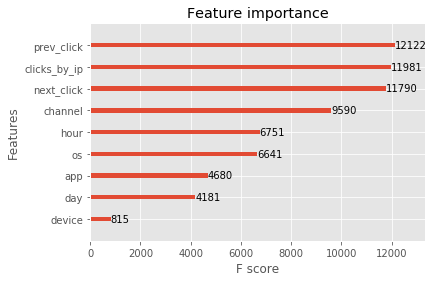

In [10]:
plot_importance(model)

In [11]:
sub = pd.DataFrame()
sub['click_id'] = test['click_id'].astype('int')

In [12]:
test.drop(['click_id'], axis=1, inplace=True)
dtest = xgb.DMatrix(test)
# del dtrain, dvalid
gc.collect()

21

In [13]:
# del train, test
# gc.collect()

In [14]:
sub['is_attributed'] = model.predict(dtest, ntree_limit=model.best_ntree_limit)

In [18]:
sub.to_csv(my_data_path / 'submit' / '003-BasicXgBoost.csv', float_format='%.8f', index=False)

In [16]:
sub.head()

,click_id,is_attributed
0,11550741,0.002273
1,13336473,0.008730
2,12821883,0.003370
3,2183157,0.035341
4,934131,0.185847


In [17]:
sub.click_id.duplicated().sum()

0